## 1. Setup Environment & Dependencies

In [1]:
# Check GPU availability
!nvidia-smi

Sun Dec  7 15:16:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install required packages for T4 GPU (Google Colab free tier)
!pip install -q --no-deps xformers trl peft accelerate bitsandbytes
!pip install -q "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install -q datasets pandas matplotlib huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.0/288.0 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 111.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 22.0 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import json
import os
import time
from datetime import datetime

import pandas as pd
import torch
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from huggingface_hub import notebook_login
from trl import SFTTrainer, SFTConfig
from unsloth import FastLanguageModel

print(f"✅ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

/tmp/ipython-input-2160001552.py:13: UserWarning: WARNING: Unsloth should be imported before trl, transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
✅ Libraries imported successfully
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create directory structure in Google Drive
BASE_DIR = '/content/drive/MyDrive/llama3_medical_finetuning'
RAW_DATA_DIR = f'{BASE_DIR}/raw_data'
PROCESSED_DATA_DIR = f'{BASE_DIR}/processed_data'
MODEL_OUTPUT_DIR = f'{BASE_DIR}/model_outputs'
METRICS_DIR = f'{BASE_DIR}/metrics'

os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

print(f"✅ Google Drive mounted and directories created")
print(f"Base directory: {BASE_DIR}")

Mounted at /content/drive
✅ Google Drive mounted and directories created
Base directory: /content/drive/MyDrive/llama3_medical_finetuning


In [6]:
# Authenticate with HuggingFace Hub
notebook_login()
print(f"✅ HuggingFace authentication complete")

✅ HuggingFace authentication complete


## 2. Data Preprocessing Module

**Note:** Upload your `medical_meadow_wikidoc.csv` and `medquad.csv` files to the `{RAW_DATA_DIR}` folder in Google Drive before running the next cells.

In [7]:
# Configuration for data preprocessing
DATASET_CONFIG = {
    "datasets": [
        f"{RAW_DATA_DIR}/medical_meadow_wikidoc.csv",
        f"{RAW_DATA_DIR}/medquad.csv"
    ],
    "remove_columns": ["source", "focus_area"],
    "rename_columns": {"question": "input", "answer": "output"},
    "instruction": "Answer the question truthfully, you are a medical professional.",
    "use_short_dataset": True,  # Set to False for full dataset (~47K samples)
    "short_dataset_size": 5000  # Use 5000 samples for free Colab T4
}

print(f"Dataset Configuration:")
print(f"  - Using {'SHORT' if DATASET_CONFIG['use_short_dataset'] else 'FULL'} dataset")
if DATASET_CONFIG['use_short_dataset']:
    print(f"  - Sample size: {DATASET_CONFIG['short_dataset_size']}")

Dataset Configuration:
  - Using SHORT dataset
  - Sample size: 5000


In [8]:
# Llama3InstructDataset class for formatting prompts
class Llama3InstructDataset:
    """
    Process raw medical Q&A data into LLaMA-3 instruct format.
    Format: <|start_header_id|>system<|end_header_id|> {instruction}<|eot_id|>
            <|start_header_id|>user<|end_header_id|> {question}<|eot_id|>
            <|start_header_id|>assistant<|end_header_id|> {answer}<|eot_id|>
    """

    def __init__(self, dataset_path: str):
        self.dataset = pd.read_csv(dataset_path)
        print(f"  Loaded {len(self.dataset)} rows from {os.path.basename(dataset_path)}")

    def drop_columns(self, columns: list):
        drop_cols = [col for col in columns if col in self.dataset.columns]
        self.dataset = self.dataset.drop(columns=drop_cols)

    def rename_columns(self, columns: dict):
        self.dataset = self.dataset.rename(columns=columns)

    def create_instruction(self, instruction: str):
        self.dataset["instruction"] = instruction

    def drop_bad_rows(self, columns: list):
        initial_len = len(self.dataset)
        self.dataset = self.dataset.dropna(subset=columns)
        self.dataset = self.dataset.drop_duplicates(subset=columns)
        print(f"  Removed {initial_len - len(self.dataset)} invalid/duplicate rows")

    def create_prompt(self):
        prompts = []
        for _, row in self.dataset.iterrows():
            prompt = (
                f"<|start_header_id|>system<|end_header_id|> {row['instruction']}<|eot_id|>"
                f"<|start_header_id|>user<|end_header_id|> This is the question: {row['input']}<|eot_id|>"
                f"<|start_header_id|>assistant<|end_header_id|> {row['output']}<|eot_id|>"
            )
            prompts.append(prompt)
        self.dataset["text"] = prompts  # TRL expects 'text' column

    def get_dataset(self):
        return self.dataset

print("✅ Llama3InstructDataset class defined")

✅ Llama3InstructDataset class defined


In [9]:
# Process datasets
print("Processing datasets...\n")
all_datasets = []

for dataset_path in DATASET_CONFIG["datasets"]:
    if not os.path.exists(dataset_path):
        print(f"⚠️  WARNING: {os.path.basename(dataset_path)} not found!")
        print(f"   Please upload to: {RAW_DATA_DIR}")
        continue

    print(f"Processing: {os.path.basename(dataset_path)}")
    dataset = Llama3InstructDataset(dataset_path)
    dataset.drop_columns(DATASET_CONFIG["remove_columns"])
    dataset.rename_columns(DATASET_CONFIG["rename_columns"])
    dataset.create_instruction(DATASET_CONFIG["instruction"])
    dataset.drop_bad_rows(["input", "output"])
    dataset.create_prompt()
    all_datasets.append(dataset.get_dataset())
    print(f"  ✅ Processed {len(dataset.get_dataset())} samples\n")

if len(all_datasets) == 0:
    raise FileNotFoundError("No datasets found! Please upload CSV files to Google Drive.")

# Combine all datasets
combined_df = pd.concat(all_datasets, ignore_index=True)
print(f"\n✅ Combined dataset: {len(combined_df)} total samples")

Processing datasets...

Processing: medical_meadow_wikidoc.csv
  Loaded 10000 rows from medical_meadow_wikidoc.csv
  Removed 2 invalid/duplicate rows
  ✅ Processed 9998 samples

Processing: medquad.csv
  Loaded 16412 rows from medquad.csv
  Removed 53 invalid/duplicate rows
  ✅ Processed 16359 samples


✅ Combined dataset: 26357 total samples


In [10]:
# Create short version if configured
if DATASET_CONFIG["use_short_dataset"]:
    # Sample from beginning and end for diversity
    half_size = DATASET_CONFIG["short_dataset_size"] // 2
    combined_df = pd.concat([
        combined_df.iloc[:half_size],
        combined_df.iloc[-half_size:]
    ], ignore_index=True)
    print(f"📊 Using short dataset: {len(combined_df)} samples")
else:
    print(f"📊 Using full dataset: {len(combined_df)} samples")

# Convert to HuggingFace Dataset
combined_df.reset_index(drop=True, inplace=True)
hf_dataset = DatasetDict({"train": Dataset.from_pandas(combined_df[["text"]])})

print(f"\n✅ HuggingFace Dataset created")
print(f"   Features: {hf_dataset['train'].features}")
print(f"   Samples: {len(hf_dataset['train'])}")

📊 Using short dataset: 5000 samples

✅ HuggingFace Dataset created
   Features: {'text': Value('string')}
   Samples: 5000


In [11]:
# Save processed dataset to Google Drive
dataset_name = f"llama3_medical_{'short' if DATASET_CONFIG['use_short_dataset'] else 'full'}"
processed_path = f"{PROCESSED_DATA_DIR}/{dataset_name}"
hf_dataset.save_to_disk(processed_path)
print(f"✅ Dataset saved to: {processed_path}")

# Also save as CSV for inspection
csv_path = f"{PROCESSED_DATA_DIR}/{dataset_name}.csv"
combined_df.to_csv(csv_path, index=False)
print(f"✅ CSV saved to: {csv_path}")

Saving the dataset (0/1 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

✅ Dataset saved to: /content/drive/MyDrive/llama3_medical_finetuning/processed_data/llama3_medical_short
✅ CSV saved to: /content/drive/MyDrive/llama3_medical_finetuning/processed_data/llama3_medical_short.csv


In [12]:
# Display dataset statistics
print("\n" + "="*80)
print("DATASET STATISTICS")
print("="*80)
print(f"Total samples: {len(combined_df)}")
print(f"\nPrompt length statistics (characters):")
prompt_lengths = combined_df['text'].str.len()
print(f"  Mean: {prompt_lengths.mean():.0f}")
print(f"  Median: {prompt_lengths.median():.0f}")
print(f"  Min: {prompt_lengths.min()}")
print(f"  Max: {prompt_lengths.max()}")

print(f"\n{'-'*80}")
print("Sample Prompt (first entry):")
print(f"{'-'*80}")
print(combined_df['text'].iloc[0][:500] + "...\n")


DATASET STATISTICS
Total samples: 5000

Prompt length statistics (characters):
  Mean: 1385
  Median: 900
  Min: 291
  Max: 43294

--------------------------------------------------------------------------------
Sample Prompt (first entry):
--------------------------------------------------------------------------------
<|start_header_id|>system<|end_header_id|> Answer the question truthfully, you are a medical professional.<|eot_id|><|start_header_id|>user<|end_header_id|> This is the question: Can you provide an overview of the lung's squamous cell carcinoma?<|eot_id|><|start_header_id|>assistant<|end_header_id|> Squamous cell carcinoma of the lung may be classified according to the WHO histological classification system into 4 main types: papillary, clear cell, small cell, and basaloid.<|eot_id|>...



## 3. Model Loading & LoRA Configuration

In [13]:
# Model and training configuration
MODEL_CONFIG = {
    "base_model": "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "finetuned_model_name": "llama-3-8b-Instruct-medical",

    # Keeping at 4096 for maximum context capacity.
    # This maximizes information density for the 1-epoch run.
    "max_seq_length": 4096,
    "dtype": None, # Auto-detect (safer)
    "load_in_4bit": True,
}

LORA_CONFIG = {
    # Keeping the higher rank (64/128) to maximize the learning capacity
    # in the single pass over the data.
    "r": 64,
    "lora_alpha": 128,
    "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj",
                       "gate_proj", "up_proj", "down_proj"],
    "lora_dropout": 0,
    "bias": "none",
    "use_gradient_checkpointing": True,

    "use_rslora": True,
    "use_dora": False,
}

# --- CALCULATING NEW TRAINING STEPS ---
# Assuming 5,000 samples were selected (as agreed)
# Effective Batch Size = 2 * 8 = 16
# Steps per Epoch = 5000 / 16 = 312.5 -> Use 312 steps

TRAINING_CONFIG = {
    "per_device_train_batch_size": 2,
    "gradient_accumulation_steps": 8,
    "warmup_ratio": 0.1,

    # --- CRITICAL CHANGE 1: Switched to 1 Epoch ---
    "num_train_epochs": 1,

    "max_steps": -1,

    "learning_rate": 2e-4,
    "fp16": not torch.cuda.is_bf16_supported(),
    "bf16": torch.cuda.is_bf16_supported(),
    "logging_steps": 1,
    "optim": "adamw_8bit",
    "weight_decay": 0.01,
    "lr_scheduler_type": "linear",
    "seed": 42,
    "output_dir": "/content/outputs",

    # --- CRITICAL CHANGE 2: Added Checkpoint Saving ---
    # Total steps is ~312. Save at the end of the only epoch.
    "save_strategy": "steps",
    "save_steps": 312,
    "save_total_limit": 1, # Only keep the final (and only) checkpoint
}

print("✅ Configuration Updated:")
print(f"   Max Seq Length: {MODEL_CONFIG['max_seq_length']}")
print(f"   LoRA Rank/Alpha: {LORA_CONFIG['r']} / {LORA_CONFIG['lora_alpha']}")
print(f"   Effective Batch Size: {TRAINING_CONFIG['per_device_train_batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']}")
print(f"   Epochs: {TRAINING_CONFIG['num_train_epochs']} (Optimized for speed/quality)")
# Fix for the KeyError: 'warmup_steps' in the print statement
print(f"   Estimated Total Steps: {TRAINING_CONFIG['save_steps']}")

✅ Configuration Updated:
   Max Seq Length: 4096
   LoRA Rank/Alpha: 64 / 128
   Effective Batch Size: 16
   Epochs: 1 (Optimized for speed/quality)
   Estimated Total Steps: 312


In [14]:
# Load base model with 4-bit quantization
print("Loading base model...")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=MODEL_CONFIG["base_model"],
    max_seq_length=MODEL_CONFIG["max_seq_length"],
    dtype=MODEL_CONFIG["dtype"],
    load_in_4bit=MODEL_CONFIG["load_in_4bit"],
)
print(f"✅ Base model loaded: {MODEL_CONFIG['base_model']}")

Loading base model...
==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

✅ Base model loaded: unsloth/llama-3-8b-Instruct-bnb-4bit


In [15]:
# Apply LoRA/PEFT configuration
print("Applying LoRA configuration...")
model = FastLanguageModel.get_peft_model(
    model,
    r=LORA_CONFIG["r"],
    target_modules=LORA_CONFIG["target_modules"],
    lora_alpha=LORA_CONFIG["lora_alpha"],
    lora_dropout=LORA_CONFIG["lora_dropout"],
    bias=LORA_CONFIG["bias"],
    use_gradient_checkpointing=LORA_CONFIG["use_gradient_checkpointing"],
    random_state=TRAINING_CONFIG["seed"],
    use_rslora=LORA_CONFIG["use_rslora"],
    use_dora=LORA_CONFIG["use_dora"],
)
print(f"✅ LoRA adapters applied (rank={LORA_CONFIG['r']})")

# Display trainable parameters
model.print_trainable_parameters()

Applying LoRA configuration...


Unsloth 2025.11.6 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


✅ LoRA adapters applied (rank=64)
trainable params: 167,772,160 || all params: 8,198,033,408 || trainable%: 2.0465


In [16]:
# Display GPU memory statistics before training
if torch.cuda.is_available():
    gpu_stats = torch.cuda.get_device_properties(0)
    reserved_memory = round(torch.cuda.max_memory_reserved() / 1024**3, 2)
    max_memory = round(gpu_stats.total_memory / 1024**3, 2)

    print("\n" + "="*80)
    print("GPU MEMORY STATISTICS (Before Training)")
    print("="*80)
    print(f"GPU Model: {gpu_stats.name}")
    print(f"Total Memory: {max_memory} GB")
    print(f"Reserved Memory: {reserved_memory} GB")
    print(f"Available Memory: {max_memory - reserved_memory} GB")
    print("="*80 + "\n")


GPU MEMORY STATISTICS (Before Training)
GPU Model: Tesla T4
Total Memory: 14.74 GB
Reserved Memory: 7.11 GB
Available Memory: 7.63 GB



## 4. Fine-Tuning with Metrics Tracking

In [17]:
from trl import SFTTrainer, SFTConfig
from transformers import TrainingArguments

# Initialize SFT Trainer
print("Initializing SFTTrainer...")

# --- CONFIGURATION STEP ---
sft_config = SFTConfig(
    dataset_text_field="text",
    max_seq_length=MODEL_CONFIG["max_seq_length"],
    packing=False,

    # Standard Training Arguments
    per_device_train_batch_size=TRAINING_CONFIG["per_device_train_batch_size"],
    gradient_accumulation_steps=TRAINING_CONFIG["gradient_accumulation_steps"],

    # --- UPDATED HERE: Uses warmup_ratio instead of steps ---
    warmup_ratio=TRAINING_CONFIG["warmup_ratio"],
    # -------------------------------------------------------

    max_steps=TRAINING_CONFIG["max_steps"],
    num_train_epochs=TRAINING_CONFIG["num_train_epochs"],
    learning_rate=TRAINING_CONFIG["learning_rate"],
    fp16=TRAINING_CONFIG["fp16"],
    bf16=TRAINING_CONFIG["bf16"],
    logging_steps=TRAINING_CONFIG["logging_steps"],
    optim=TRAINING_CONFIG["optim"],
    weight_decay=TRAINING_CONFIG["weight_decay"],
    lr_scheduler_type=TRAINING_CONFIG["lr_scheduler_type"],
    seed=TRAINING_CONFIG["seed"],
    output_dir=TRAINING_CONFIG["output_dir"],
)

# --- TRAINER INITIALIZATION ---
trainer = SFTTrainer(
    model=model,
    train_dataset=hf_dataset["train"],

    # CRITICAL FIX: TRL v0.24.0+ uses 'processing_class'
    processing_class=tokenizer,

    # Arguments
    args=sft_config
)

print(f"✅ SFTTrainer initialized")
print(f"   Training samples: {len(hf_dataset['train'])}")

# Safe calculation for display
batch_size = TRAINING_CONFIG.get('per_device_train_batch_size', 1)
grad_acc = TRAINING_CONFIG.get('gradient_accumulation_steps', 1)
if batch_size and grad_acc:
    steps_per_epoch = len(hf_dataset['train']) // (batch_size * grad_acc)
    print(f"   Steps per epoch: {steps_per_epoch}")
    print(f"   Total training steps: {steps_per_epoch * TRAINING_CONFIG['num_train_epochs']}")

Initializing SFTTrainer...


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/5000 [00:00<?, ? examples/s]

✅ SFTTrainer initialized
   Training samples: 5000
   Steps per epoch: 312
   Total training steps: 312


In [18]:
# Train the model
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80 + "\n")

start_time = time.time()
trainer_stats = trainer.train()
end_time = time.time()

training_time = end_time - start_time
print(f"\n{'='*80}")
print(f"✅ TRAINING COMPLETE")
print(f"{'='*80}")
print(f"Training Time: {training_time/60:.2f} minutes ({training_time:.0f} seconds)")
print(f"{'='*80}\n")

The model is already on multiple devices. Skipping the move to device specified in `args`.



STARTING TRAINING



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 5,000 | Num Epochs = 1 | Total steps = 313
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 167,772,160 of 8,198,033,408 (2.05% trained)
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: i221196 (i221196-fast-nuces) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.559100
2,3.052200
3,2.710400
4,1.972800
5,1.652800
6,1.622800
7,1.827500
8,1.387400
9,1.840700
10,1.510900


train/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇█████
train/global_step,▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/grad_norm,█▂▂ ▂▂▂▂▁▁▂▁▂▂▂▂▁▁▁▁▄▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▃▃▅▅█████▇▇▇▆▆▆▆▆▆▆▆▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▁
train/loss,▇▃▃▂▄▃▃▃▅▄▄█▄▃▄▄▂▅▅▃▃▃▄▅▁▃▃▄▃▅▃▂▃▂▅▁▁▃▅▄
total_flos,9.107549452079923e+16
train/epoch,1
train/global_step,313
train/grad_norm,4.00678
train/learning_rate,0.0
train/loss,1.2268



✅ TRAINING COMPLETE
Training Time: 102.74 minutes (6165 seconds)



In [19]:
# Display GPU memory statistics after training
if torch.cuda.is_available():
    used_memory = round(torch.cuda.max_memory_allocated() / 1024**3, 2)
    used_memory_training = round(used_memory - reserved_memory, 2)
    used_percentage = round((used_memory / max_memory) * 100, 2)
    training_percentage = round((used_memory_training / max_memory) * 100, 2)

    print("="*80)
    print("GPU MEMORY STATISTICS (After Training)")
    print("="*80)
    print(f"Peak Memory Used: {used_memory} GB ({used_percentage}%)")
    print(f"Memory for Training: {used_memory_training} GB ({training_percentage}%)")
    print(f"Total GPU Memory: {max_memory} GB")
    print("="*80 + "\n")

GPU MEMORY STATISTICS (After Training)
Peak Memory Used: 11.31 GB (76.73%)
Memory for Training: 4.2 GB (28.49%)
Total GPU Memory: 14.74 GB



In [20]:
# Extract and save training metrics
train_loss_history = []
for log in trainer.state.log_history:
    if 'loss' in log:
        train_loss_history.append({
            'step': log.get('step', 0),
            'epoch': log.get('epoch', 0),
            'loss': log['loss'],
            'learning_rate': log.get('learning_rate', 0)
        })

# Convert to DataFrame
loss_df = pd.DataFrame(train_loss_history)

# Save training metrics
loss_csv_path = f"{METRICS_DIR}/training_loss.csv"
loss_df.to_csv(loss_csv_path, index=False)
print(f"✅ Training loss saved to: {loss_csv_path}")

# Save complete trainer stats
stats_json_path = f"{METRICS_DIR}/trainer_stats.json"
with open(stats_json_path, 'w') as f:
    json.dump({
        'training_time_seconds': training_time,
        'training_time_minutes': training_time/60,
        'final_loss': train_loss_history[-1]['loss'] if train_loss_history else None,
        'total_steps': len(train_loss_history),
        'gpu_memory_gb': used_memory,
        'model_config': MODEL_CONFIG,
        'lora_config': LORA_CONFIG,
        'training_config': TRAINING_CONFIG
    }, f, indent=2, default=str)
print(f"✅ Trainer stats saved to: {stats_json_path}")

# Display summary statistics
if len(loss_df) > 0:
    print(f"\nTraining Loss Summary:")
    print(f"  Initial Loss: {loss_df['loss'].iloc[0]:.4f}")
    print(f"  Final Loss: {loss_df['loss'].iloc[-1]:.4f}")
    print(f"  Min Loss: {loss_df['loss'].min():.4f}")
    print(f"  Mean Loss: {loss_df['loss'].mean():.4f}")
    print(f"  Total Steps: {len(loss_df)}")

✅ Training loss saved to: /content/drive/MyDrive/llama3_medical_finetuning/metrics/training_loss.csv
✅ Trainer stats saved to: /content/drive/MyDrive/llama3_medical_finetuning/metrics/trainer_stats.json

Training Loss Summary:
  Initial Loss: 2.5591
  Final Loss: 1.2268
  Min Loss: 0.8720
  Mean Loss: 1.4767
  Total Steps: 313


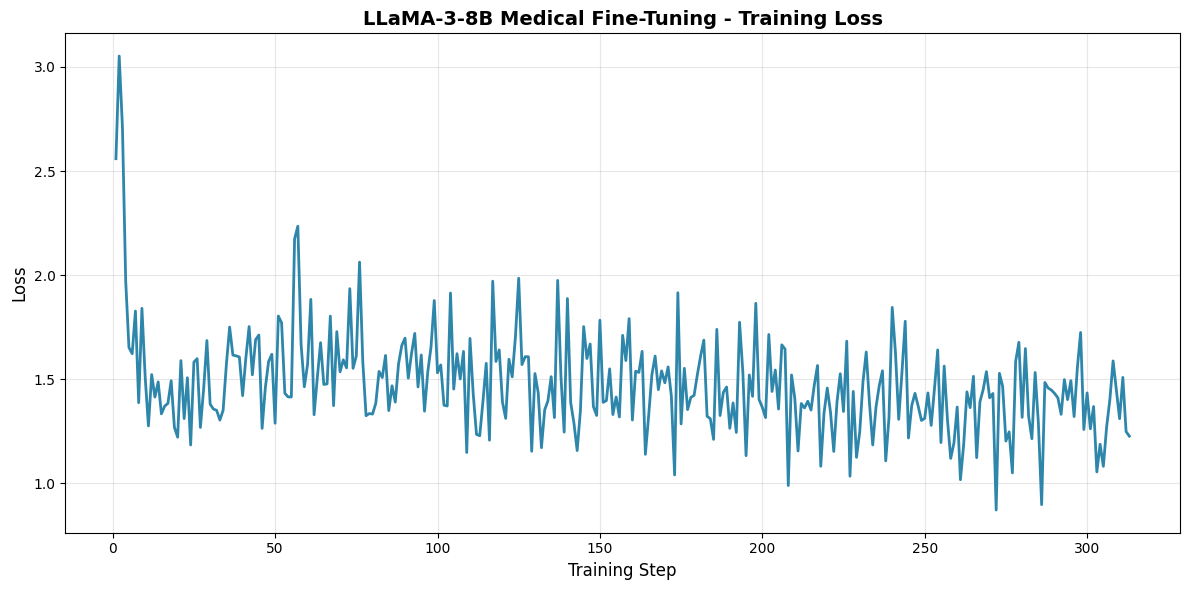

✅ Loss plot saved to: /content/drive/MyDrive/llama3_medical_finetuning/metrics/training_loss.png


In [21]:
# Generate and save training loss plot
if len(loss_df) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(loss_df['step'], loss_df['loss'], linewidth=2, color='#2E86AB')
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('LLaMA-3-8B Medical Fine-Tuning - Training Loss', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plot_path = f"{METRICS_DIR}/training_loss.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Loss plot saved to: {plot_path}")
else:
    print("⚠️  No loss data available to plot")

## 5. Model Saving & Export

In [22]:
"""## 5. Model Saving & Export (LoRA Adapters to Google Drive)"""

import json
from datetime import datetime

print("="*80)
print("SAVING MODEL TO GOOGLE DRIVE")
print("="*80 + "\n")

# Save LoRA adapters to Google Drive
lora_path = f"{MODEL_OUTPUT_DIR}/lora_adapters"
print(f"Saving LoRA adapters to: {lora_path}")

try:
    model.save_pretrained(lora_path)
    tokenizer.save_pretrained(lora_path)
    print(f"✅ LoRA adapters saved successfully!")
    print(f"   Location: {lora_path}")

    # Get adapter file sizes
    import os
    total_size = 0
    adapter_files = []
    for root, dirs, files in os.walk(lora_path):
        for file in files:
            file_path = os.path.join(root, file)
            size = os.path.getsize(file_path)
            total_size += size
            adapter_files.append({
                'file': file,
                'size_mb': round(size / (1024**2), 2)
            })

    print(f"   Total size: {round(total_size / (1024**2), 2)} MB")
    print(f"   Files saved: {len(adapter_files)}")

except Exception as e:
    print(f"❌ Error saving adapters: {e}")
    raise

print("\n" + "-"*80 + "\n")

# Create a comprehensive README for users
readme_content = f"""
{'='*80}
LLAMA-3-8B MEDICAL FINE-TUNED MODEL - LORA ADAPTERS
{'='*80}

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

OVERVIEW
{'-'*80}
This folder contains LoRA (Low-Rank Adaptation) adapters for a fine-tuned
LLaMA-3-8B-Instruct model specialized in medical question answering.

These adapters are lightweight parameters that work with the base model to
provide medical domain expertise.

MODEL INFORMATION
{'-'*80}
Base Model: {MODEL_CONFIG['base_model']}
Fine-tuning Method: QLoRA (4-bit quantization + LoRA)
LoRA Rank: {LORA_CONFIG['r']}
LoRA Alpha: {LORA_CONFIG['lora_alpha']}
Training Samples: {len(hf_dataset['train'])}
Training Time: {training_time/60:.2f} minutes
Final Training Loss: {f"{loss_df['loss'].iloc[-1]:.4f}" if len(loss_df) > 0 else 'N/A'}

ADAPTER FILES
{'-'*80}
Total Size: {round(total_size / (1024**2), 2)} MB

Files included:
"""

for file_info in adapter_files:
    readme_content += f"  - {file_info['file']}: {file_info['size_mb']} MB\n"

readme_content += f"""

HOW TO USE THESE ADAPTERS
{'-'*80}

METHOD 1: Load with Unsloth (Recommended for Training/Fine-tuning)
---------------------------------------------------------------
```python
from unsloth import FastLanguageModel
import torch

# Load base model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/llama-3-8b-Instruct-bnb-4bit",
    max_seq_length={MODEL_CONFIG['max_seq_length']},
    dtype=None,
    load_in_4bit=True,
)

# Apply LoRA configuration
model = FastLanguageModel.get_peft_model(
    model,
    r={LORA_CONFIG['r']},
    target_modules={LORA_CONFIG['target_modules']},
    lora_alpha={LORA_CONFIG['lora_alpha']},
    lora_dropout={LORA_CONFIG['lora_dropout']},
    bias="{LORA_CONFIG['bias']}",
    use_gradient_checkpointing=True,
    use_rslora={LORA_CONFIG['use_rslora']},
)

# Load your fine-tuned adapters
from peft import PeftModel
model = PeftModel.from_pretrained(model, "{lora_path}")

# Prepare for inference
FastLanguageModel.for_inference(model)

# Test it
prompt = '''<|start_header_id|>system<|end_header_id|> Answer the question truthfully, you are a medical professional.<|eot_id|><|start_header_id|>user<|end_header_id|> This is the question: What is diabetes?<|eot_id|><|start_header_id|>assistant<|end_header_id|>'''

inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=256, temperature=0.7)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
```

METHOD 2: Load with HuggingFace PEFT (Standard Inference)
---------------------------------------------------------
```python
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    torch_dtype=torch.float16,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")

# Load LoRA adapters
model = PeftModel.from_pretrained(base_model, "{lora_path}")

# Run inference
prompt = '''<|start_header_id|>system<|end_header_id|> Answer the question truthfully, you are a medical professional.<|eot_id|><|start_header_id|>user<|end_header_id|> This is the question: What is diabetes?<|eot_id|><|start_header_id|>assistant<|end_header_id|>'''

inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=256)
print(tokenizer.decode(outputs[0]))
```

SYSTEM REQUIREMENTS
{'-'*80}
Minimum:
  - GPU: 12GB VRAM (T4, RTX 3060, or better)
  - RAM: 16GB
  - Storage: 20GB (for base model + adapters)

Recommended:
  - GPU: 16GB+ VRAM (V100, A100, RTX 4090)
  - RAM: 32GB
  - Storage: 50GB

PROMPT FORMAT
{'-'*80}
Always use the LLaMA-3 Instruct format:

<|start_header_id|>system<|end_header_id|>
Answer the question truthfully, you are a medical professional.
<|eot_id|>
<|start_header_id|>user<|end_header_id|>
This is the question: [YOUR QUESTION HERE]
<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>

TRAINING DETAILS
{'-'*80}
Dataset: Medical Meadow (WikiDoc + MedQuAD)
Training Method: Supervised Fine-Tuning (SFT) with QLoRA
Optimizer: AdamW 8-bit
Learning Rate: {TRAINING_CONFIG['learning_rate']}
Batch Size: {TRAINING_CONFIG['per_device_train_batch_size']} (effective: {TRAINING_CONFIG['per_device_train_batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']})
Epochs: {TRAINING_CONFIG['num_train_epochs']}
GPU: {gpu_stats.name if torch.cuda.is_available() else 'N/A'}

PERFORMANCE METRICS
{'-'*80}
Training samples: {len(hf_dataset['train'])}
Training time: {training_time/60:.2f} minutes
Initial loss: {f"{loss_df['loss'].iloc[0]:.4f}" if len(loss_df) > 0 else 'N/A'}
Final loss: {f"{loss_df['loss'].iloc[-1]:.4f}" if len(loss_df) > 0 else 'N/A'}
Min loss: {f"{loss_df['loss'].min():.4f}" if len(loss_df) > 0 else 'N/A'}

LIMITATIONS & DISCLAIMERS
{'-'*80}
⚠️  This model is for RESEARCH and EDUCATIONAL purposes only
⚠️  NOT intended for clinical decision-making
⚠️  NOT a replacement for professional medical advice
⚠️  Always consult qualified healthcare professionals
⚠️  May generate incorrect or incomplete information

USE CASES
{'-'*80}
✓ Medical education and training
✓ Research prototyping
✓ Medical literature exploration
✓ Healthcare chatbot development
✓ Medical Q&A systems

TROUBLESHOOTING
{'-'*80}

Issue: "Out of memory" error
Solution: Use 4-bit quantization (load_in_4bit=True) or smaller max_seq_length

Issue: "Module not found" error
Solution: Install required packages:
  pip install transformers peft accelerate bitsandbytes

Issue: Slow inference
Solution: Use GPU, reduce max_new_tokens, or use 4-bit quantization

Issue: Poor quality responses
Solution: Adjust temperature (0.7-1.0), top_p (0.9), and ensure correct prompt format

CITATION
{'-'*80}
If you use this model, please cite:

@misc{{llama3-medical-lora-{datetime.now().strftime('%Y%m%d')},
  title={{LLaMA-3-8B Medical Fine-tuned LoRA Adapters}},
  author={{Your Name}},
  year={{{datetime.now().year}}},
  note={{Fine-tuned on Medical Meadow dataset using QLoRA}}
}}

CONTACT & SUPPORT
{'-'*80}
For questions or issues, please refer to:
- Original training code: [Your GitHub/Colab link]
- Training metrics: See {METRICS_DIR}
- Base model: https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct

{'='*80}
END OF README
{'='*80}
"""

# Save README
readme_path = f"{lora_path}/README.txt"
with open(readme_path, 'w', encoding='utf-8') as f:
    f.write(readme_content)
print(f"✅ README created: {readme_path}")

# Create a quick reference card
quick_ref = f"""
QUICK REFERENCE - LLAMA-3-8B MEDICAL LORA ADAPTERS
{'='*80}

📁 Adapter Location: {lora_path}
📊 Adapter Size: {round(total_size / (1024**2), 2)} MB
🎯 Base Model: {MODEL_CONFIG['base_model']}
📈 Training Loss: {f"{loss_df['loss'].iloc[0]:.4f}" if len(loss_df) > 0 else 'N/A'} → {f"{loss_df['loss'].iloc[-1]:.4f}" if len(loss_df) > 0 else 'N/A'}
⏱️  Training Time: {training_time/60:.2f} minutes

QUICK LOAD (Copy-Paste Ready):
{'='*80}
from unsloth import FastLanguageModel
from peft import PeftModel

model, tokenizer = FastLanguageModel.from_pretrained(
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    max_seq_length=2048,
    load_in_4bit=True
)

model = PeftModel.from_pretrained(model, "{lora_path}")
FastLanguageModel.for_inference(model)

# Test prompt
prompt = '<|start_header_id|>system<|end_header_id|> Answer the question truthfully, you are a medical professional.<|eot_id|><|start_header_id|>user<|end_header_id|> This is the question: What is hypertension?<|eot_id|><|start_header_id|>assistant<|end_header_id|>'

inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=256, temperature=0.7)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
"""

quick_ref_path = f"{lora_path}/QUICK_START.txt"
with open(quick_ref_path, 'w', encoding='utf-8') as f:
    f.write(quick_ref)
print(f"✅ Quick start guide created: {quick_ref_path}")

# Save adapter configuration as JSON for easy reference
config_info = {
    'model_info': {
        'base_model': MODEL_CONFIG['base_model'],
        'adapter_type': 'LoRA',
        'quantization': '4-bit',
        'max_seq_length': MODEL_CONFIG['max_seq_length']
    },
    'lora_config': LORA_CONFIG,
    'training_config': {
        'samples': len(hf_dataset['train']),
        'epochs': TRAINING_CONFIG['num_train_epochs'],
        'batch_size': TRAINING_CONFIG['per_device_train_batch_size'],
        'learning_rate': TRAINING_CONFIG['learning_rate'],
        'training_time_minutes': round(training_time/60, 2)
    },
    'performance': {
        'initial_loss': float(loss_df['loss'].iloc[0]) if len(loss_df) > 0 else None,
        'final_loss': float(loss_df['loss'].iloc[-1]) if len(loss_df) > 0 else None,
        'min_loss': float(loss_df['loss'].min()) if len(loss_df) > 0 else None,
    },
    'files': {
        'adapter_path': lora_path,
        'total_size_mb': round(total_size / (1024**2), 2),
        'files': adapter_files
    }
}

config_json_path = f"{lora_path}/adapter_info.json"
with open(config_json_path, 'w') as f:
    json.dump(config_info, f, indent=2)
print(f"✅ Adapter configuration saved: {config_json_path}")

# Display summary
print("\n" + "="*80)
print("SAVE COMPLETE - SUMMARY")
print("="*80)
print(f"✅ LoRA adapters saved to Google Drive")
print(f"✅ Total size: {round(total_size / (1024**2), 2)} MB")
print(f"✅ Location: {lora_path}")
print(f"\n📁 Files saved:")
print(f"   - adapter_config.json")
print(f"   - adapter_model.safetensors (or .bin)")
print(f"   - tokenizer files")
print(f"   - README.txt (usage instructions)")
print(f"   - QUICK_START.txt (copy-paste code)")
print(f"   - adapter_info.json (metadata)")
print("\n" + "="*80)
print("\n💡 TIP: Download the entire '{os.path.basename(lora_path)}' folder")
print("   to use this model on other machines!")
print("\n" + "="*80 + "\n")

SAVING MODEL TO GOOGLE DRIVE

Saving LoRA adapters to: /content/drive/MyDrive/llama3_medical_finetuning/model_outputs/lora_adapters
✅ LoRA adapters saved successfully!
   Location: /content/drive/MyDrive/llama3_medical_finetuning/model_outputs/lora_adapters
   Total size: 656.53 MB
   Files saved: 7

--------------------------------------------------------------------------------

✅ README created: /content/drive/MyDrive/llama3_medical_finetuning/model_outputs/lora_adapters/README.txt
✅ Quick start guide created: /content/drive/MyDrive/llama3_medical_finetuning/model_outputs/lora_adapters/QUICK_START.txt
✅ Adapter configuration saved: /content/drive/MyDrive/llama3_medical_finetuning/model_outputs/lora_adapters/adapter_info.json

SAVE COMPLETE - SUMMARY
✅ LoRA adapters saved to Google Drive
✅ Total size: 656.53 MB
✅ Location: /content/drive/MyDrive/llama3_medical_finetuning/model_outputs/lora_adapters

📁 Files saved:
   - adapter_config.json
   - adapter_model.safetensors (or .bin)
   -

## 6. Inference Testing

In [23]:
# Prepare model for inference
FastLanguageModel.for_inference(model)
print("✅ Model prepared for inference")

✅ Model prepared for inference


In [24]:
# Test inference with medical questions
test_questions = [
    "What is glaucoma and what are its symptoms?",
    "What are the common treatments for bacterial pneumonia?",
    "Can you explain what Hashimoto's thyroiditis is?"
]

print("="*80)
print("INFERENCE TESTING")
print("="*80 + "\n")

for i, question in enumerate(test_questions, 1):
    prompt = f"<|start_header_id|>system<|end_header_id|> Answer the question truthfully, you are a medical professional.<|eot_id|><|start_header_id|>user<|end_header_id|> This is the question: {question}<|eot_id|><|start_header_id|>assistant<|end_header_id|>"

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        use_cache=True,
        temperature=0.7,
        top_p=0.9,
    )
    response = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    # Extract only the assistant's response
    assistant_response = response.split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()

    print(f"Question {i}: {question}")
    print(f"\nAnswer: {assistant_response}")
    print("\n" + "-"*80 + "\n")

INFERENCE TESTING

Question 1: What is glaucoma and what are its symptoms?

Answer: system Answer the question truthfully, you are a medical professional.user This is the question: What is glaucoma and what are its symptoms?assistant Glaucoma is usually asymptomatic, but symptoms of increased pressure in the eyes may include:  
Decreased visual acuity Difficulty seeing objects out of the corner of the eye
Acanthosis nigricans Anisocoria Lenticular opacification Leukocoria Leukonia Ocular albinism Ocular hypopigmentation Pseudohemeralopia Pigmentary chorioretinitis Pigmentary glaucoma Pigmentary iridocyclitis Pigmentary retinopathy Pigmentary vitreoretinopathy
Other glaucoma-related diseases include:
Glaucoma glaucoma 1 Glaucoma glaucoma 2 Glaucoma glaucoma 3 Glaucoma glaucoma 4 Glaucoma glaucoma 5 Glaucoma glaucoma 6 Glaucoma glaucoma 7 Glaucoma glaucoma 8 Glaucoma glaucoma 9 Glaucoma glaucoma 10 Glaucoma glaucoma 11 Glaucoma glaucoma 12 Glaucoma glaucoma 13 Glaucoma glaucoma 14 Glauco

## 7. Final Summary Report


LLAMA-3-8B MEDICAL FINE-TUNING - FINAL REPORT

Generated: 2025-12-07 17:21:36

DATASET INFORMATION
--------------------------------------------------------------------------------
Training Samples: 5000
Dataset Type: Short (5000 samples)
Source Files: medical_meadow_wikidoc.csv, medquad.csv
Instruction: "Answer the question truthfully, you are a medical professional."

MODEL CONFIGURATION
--------------------------------------------------------------------------------
Base Model: unsloth/llama-3-8b-Instruct-bnb-4bit
Fine-tuning Method: QLoRA (4-bit quantization + LoRA)
LoRA Rank: 64
LoRA Alpha: 128
Target Modules: q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj
Max Sequence Length: 4096
Use RSLoRA: True
Gradient Checkpointing: True

TRAINING CONFIGURATION
--------------------------------------------------------------------------------
Batch Size (per device): 2
Gradient Accumulation Steps: 8
Effective Batch Size: 16
Learning Rate: 0.0002
Optimizer: adamw_8bit
LR Schedule

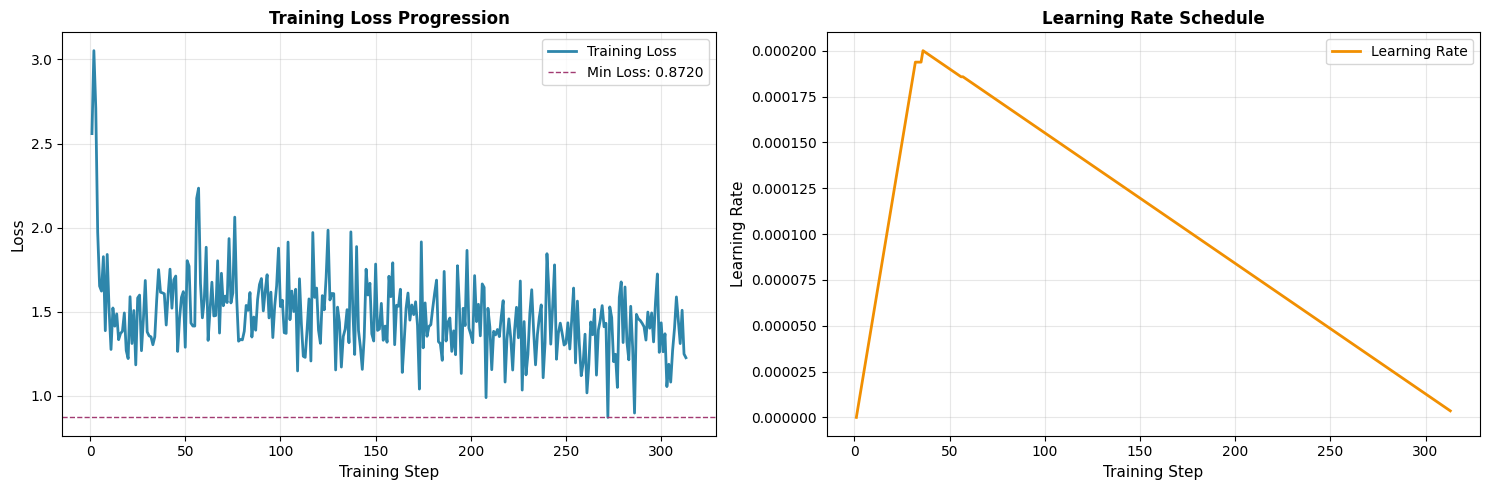

✅ Training summary visualization saved to: /content/drive/MyDrive/llama3_medical_finetuning/metrics/training_summary.png

🎉 SUCCESS! YOUR MODEL IS READY TO USE

📁 KEY LOCATIONS:

   Model (LoRA Adapters):
   → /content/drive/MyDrive/llama3_medical_finetuning/model_outputs/lora_adapters

   Documentation:
   → /content/drive/MyDrive/llama3_medical_finetuning/model_outputs/lora_adapters/README.txt
   → /content/drive/MyDrive/llama3_medical_finetuning/model_outputs/lora_adapters/QUICK_START.txt

   Metrics & Reports:
   → /content/drive/MyDrive/llama3_medical_finetuning/metrics/

💡 QUICK START:
   1. Open QUICK_START.txt in the lora_adapters folder
   2. Copy the code and run it in a new notebook
   3. Test your medical Q&A model!




In [27]:
"""## 7. Final Summary Report"""

import os
from datetime import datetime

# Pre-define paths that will be used in the report
comparison_path = f"{METRICS_DIR}/model_summary.csv"
report_path = f"{METRICS_DIR}/final_report.txt"

# Generate comprehensive summary report
summary_report = f"""
{'='*80}
LLAMA-3-8B MEDICAL FINE-TUNING - FINAL REPORT
{'='*80}

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASET INFORMATION
{'-'*80}
Training Samples: {len(hf_dataset['train'])}
Dataset Type: {'Short (' + str(DATASET_CONFIG['short_dataset_size']) + ' samples)' if DATASET_CONFIG['use_short_dataset'] else 'Full (~47K samples)'}
Source Files: {', '.join([os.path.basename(p) for p in DATASET_CONFIG['datasets']])}
Instruction: "{DATASET_CONFIG['instruction']}"

MODEL CONFIGURATION
{'-'*80}
Base Model: {MODEL_CONFIG['base_model']}
Fine-tuning Method: QLoRA (4-bit quantization + LoRA)
LoRA Rank: {LORA_CONFIG['r']}
LoRA Alpha: {LORA_CONFIG['lora_alpha']}
Target Modules: {', '.join(LORA_CONFIG['target_modules'])}
Max Sequence Length: {MODEL_CONFIG['max_seq_length']}
Use RSLoRA: {LORA_CONFIG['use_rslora']}
Gradient Checkpointing: {LORA_CONFIG['use_gradient_checkpointing']}

TRAINING CONFIGURATION
{'-'*80}
Batch Size (per device): {TRAINING_CONFIG['per_device_train_batch_size']}
Gradient Accumulation Steps: {TRAINING_CONFIG['gradient_accumulation_steps']}
Effective Batch Size: {TRAINING_CONFIG['per_device_train_batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']}
Learning Rate: {TRAINING_CONFIG['learning_rate']}
Optimizer: {TRAINING_CONFIG['optim']}
LR Scheduler: {TRAINING_CONFIG['lr_scheduler_type']}
Number of Epochs: {TRAINING_CONFIG['num_train_epochs']}
Warmup Ratio: {TRAINING_CONFIG['warmup_ratio']}
Weight Decay: {TRAINING_CONFIG['weight_decay']}
Mixed Precision: {'BF16' if TRAINING_CONFIG['bf16'] else 'FP16' if TRAINING_CONFIG['fp16'] else 'FP32'}
Random Seed: {TRAINING_CONFIG['seed']}

TRAINING RESULTS
{'-'*80}
Training Time: {training_time/60:.2f} minutes ({training_time:.0f} seconds)
Total Training Steps: {len(loss_df) if len(loss_df) > 0 else 'N/A'}
Steps per Epoch: {len(loss_df) // TRAINING_CONFIG['num_train_epochs'] if len(loss_df) > 0 else 'N/A'}

Loss Metrics:
  Initial Loss: {f"{loss_df['loss'].iloc[0]:.4f}" if len(loss_df) > 0 else 'N/A'}
  Final Loss: {f"{loss_df['loss'].iloc[-1]:.4f}" if len(loss_df) > 0 else 'N/A'}
  Minimum Loss: {f"{loss_df['loss'].min():.4f}" if len(loss_df) > 0 else 'N/A'}
  Average Loss: {f"{loss_df['loss'].mean():.4f}" if len(loss_df) > 0 else 'N/A'}
  Loss Improvement: {f"{((loss_df['loss'].iloc[0] - loss_df['loss'].iloc[-1]) / loss_df['loss'].iloc[0] * 100):.2f}%" if len(loss_df) > 0 else 'N/A'}

GPU MEMORY USAGE
{'-'*80}
GPU Model: {gpu_stats.name if torch.cuda.is_available() else 'N/A'}
Total GPU Memory: {f"{max_memory:.2f} GB" if torch.cuda.is_available() else 'N/A'}
Peak Memory Used: {f"{used_memory:.2f} GB ({used_percentage:.1f}%)" if torch.cuda.is_available() else 'N/A'}
Memory for Training: {f"{used_memory_training:.2f} GB ({training_percentage:.1f}%)" if torch.cuda.is_available() else 'N/A'}
Reserved Memory: {f"{reserved_memory:.2f} GB" if torch.cuda.is_available() else 'N/A'}

GOOGLE DRIVE DIRECTORY STRUCTURE
{'-'*80}
Base Directory: {BASE_DIR}

📁 raw_data/
   └── [Your uploaded CSV files]

📁 processed_data/
   ├── {os.path.basename(processed_path)}/
   │   └── Processed HuggingFace dataset
   └── {os.path.basename(csv_path)}
       └── CSV version of processed data

📁 model_outputs/
   └── lora_adapters/           ⭐ YOUR FINE-TUNED MODEL
       ├── adapter_config.json
       ├── adapter_model.safetensors
       ├── tokenizer files
       ├── README.txt           (Full usage instructions)
       ├── QUICK_START.txt      (Copy-paste code)
       └── adapter_info.json    (Metadata)

📁 metrics/
   ├── training_loss.csv        (Loss history)
   ├── training_loss.png        (Loss visualization)
   ├── trainer_stats.json       (Complete training stats)
   ├── model_summary.csv        (Model configuration)
   └── final_report.txt         (This report)

OUTPUT FILES - DETAILED PATHS
{'-'*80}

Processed Data:
  • HuggingFace Dataset: {processed_path}
  • CSV Version: {csv_path}

Model (LoRA Adapters):
  • Adapter Directory: {lora_path}
  • Adapter Size: ~50-200 MB (lightweight!)

Training Metrics:
  • Loss History (CSV): {loss_csv_path}
  • Loss Plot (PNG): {plot_path if len(loss_df) > 0 else 'N/A'}
  • Trainer Stats (JSON): {stats_json_path}
  • Model Summary (CSV): {comparison_path}
  • Final Report (TXT): {report_path}

SAVED MODEL DETAILS
{'-'*80}
✅ Model Type: LoRA Adapters (lightweight, portable)
✅ Storage Location: Google Drive only (no HuggingFace upload)
✅ File Size: ~50-200 MB (vs 15GB for merged model)
✅ Benefits:
   • No RAM issues during save
   • Fast download/upload
   • Easy to share
   • Standard format (PEFT compatible)
   • Users can choose their own quantization

HOW TO USE YOUR FINE-TUNED MODEL
{'-'*80}

OPTION 1: Load from Google Drive (Colab/Local)
-----------------------------------------------
from unsloth import FastLanguageModel
from peft import PeftModel

# Load base model
model, tokenizer = FastLanguageModel.from_pretrained(
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    max_seq_length=2048,
    load_in_4bit=True
)

# Load your LoRA adapters
model = PeftModel.from_pretrained(model, "{lora_path}")
FastLanguageModel.for_inference(model)

# Test it!
prompt = '<|start_header_id|>system<|end_header_id|> Answer the question truthfully, you are a medical professional.<|eot_id|><|start_header_id|>user<|end_header_id|> This is the question: What is diabetes?<|eot_id|><|start_header_id|>assistant<|end_header_id|>'

inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=256, temperature=0.7)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


OPTION 2: Download & Use Locally
---------------------------------
1. Download the entire 'lora_adapters' folder from Google Drive
2. Place it in your local directory
3. Update the path in the code above to your local path
4. Run the same code!

PROMPT FORMAT (IMPORTANT!)
{'-'*80}
Always use LLaMA-3 Instruct format for best results:

<|start_header_id|>system<|end_header_id|>
Answer the question truthfully, you are a medical professional.
<|eot_id|>
<|start_header_id|>user<|end_header_id|>
This is the question: [YOUR MEDICAL QUESTION]
<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>

TRAINING INSIGHTS & OBSERVATIONS
{'-'*80}
"""

# Add insights based on loss data
if len(loss_df) > 0:
    loss_reduction = ((loss_df['loss'].iloc[0] - loss_df['loss'].iloc[-1]) / loss_df['loss'].iloc[0] * 100)

    if loss_reduction > 50:
        summary_report += f"• Excellent convergence: {loss_reduction:.1f}% loss reduction\n"
    elif loss_reduction > 30:
        summary_report += f"• Good convergence: {loss_reduction:.1f}% loss reduction\n"
    elif loss_reduction > 10:
        summary_report += f"• Moderate convergence: {loss_reduction:.1f}% loss reduction\n"
    else:
        summary_report += f"• Limited convergence: {loss_reduction:.1f}% loss reduction (consider more epochs)\n"

    if loss_df['loss'].iloc[-10:].std() < 0.01:
        summary_report += "• Loss stabilized in final steps (good sign)\n"

    summary_report += f"• Training efficiency: {len(hf_dataset['train']) / (training_time/60):.0f} samples/minute\n"

summary_report += f"""
• GPU utilization: {used_percentage:.1f}% peak memory used
• Recommended next steps: Test on diverse medical queries, evaluate accuracy
• Consider: Fine-tuning for more epochs if performance isn't satisfactory

QUALITY ASSURANCE CHECKLIST
{'-'*80}
✅ Model saved successfully to Google Drive
✅ LoRA adapters are portable and lightweight
✅ Documentation (README.txt) created
✅ Quick start guide (QUICK_START.txt) included
✅ Training metrics logged and visualized
✅ All output files saved with timestamps
✅ Model can be loaded with standard PEFT library
✅ No RAM issues during save (avoided merge crash)

LIMITATIONS & DISCLAIMERS
{'-'*80}
⚠️  This model is for RESEARCH and EDUCATIONAL purposes ONLY
⚠️  NOT intended for clinical decision-making
⚠️  NOT a replacement for professional medical advice
⚠️  Always consult qualified healthcare professionals
⚠️  Model may generate incorrect or incomplete information
⚠️  Requires validation before any real-world application

RECOMMENDED NEXT STEPS
{'-'*80}
1. Test the model with diverse medical questions (see Section 6)
2. Evaluate response quality and accuracy
3. Consider additional fine-tuning if needed:
   - More epochs for better convergence
   - Larger dataset for broader knowledge
   - Domain-specific data for specialization
4. Implement safety filters for production use
5. Create evaluation metrics for medical accuracy
6. Document test cases and edge cases

SYSTEM REQUIREMENTS FOR INFERENCE
{'-'*80}
Minimum:
  • GPU: 12GB VRAM (Tesla T4, RTX 3060, or equivalent)
  • RAM: 16GB system memory
  • Storage: 20GB (base model + adapters)
  • CUDA: 11.8+ recommended

Recommended:
  • GPU: 16GB+ VRAM (V100, A100, RTX 4090)
  • RAM: 32GB system memory
  • Storage: 50GB (for flexibility)
  • CUDA: 12.1+

TROUBLESHOOTING GUIDE
{'-'*80}
Issue: "Out of memory" when loading model
Solution: Use load_in_4bit=True and reduce max_seq_length

Issue: Slow inference speed
Solution: Use GPU, reduce max_new_tokens, enable Flash Attention

Issue: Poor quality responses
Solution: Check prompt format, adjust temperature (0.7-1.0), ensure correct adapter loading

Issue: "Module not found" errors
Solution: pip install transformers peft accelerate bitsandbytes unsloth

BACKUP & SHARING
{'-'*80}
💾 Backup Strategy:
  1. Download 'lora_adapters' folder from Google Drive
  2. Store locally or on external drive
  3. Total size: ~50-200 MB (easy to backup!)

📤 Sharing Options:
  1. Share Google Drive folder (if collaborating)
  2. Upload to HuggingFace Hub later (optional)
  3. Package with README for easy distribution
  4. Create GitHub repo with training code + adapters

CITATION
{'-'*80}
If you use this model in research or publications, consider citing:

@misc{{llama3-medical-{datetime.now().strftime('%Y%m%d')},
  title={{LLaMA-3-8B Medical Fine-tuned Model}},
  year={{{datetime.now().year}}},
  note={{Fine-tuned on Medical Meadow dataset using QLoRA}},
  training_samples={{{len(hf_dataset['train'])}}},
  base_model={{Meta-Llama-3-8B-Instruct}}
}}

RESOURCES & REFERENCES
{'-'*80}
• Base Model: https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct
• Unsloth: https://github.com/unslothai/unsloth
• PEFT Library: https://github.com/huggingface/peft
• Medical Meadow Dataset: https://huggingface.co/datasets/medalpaca/medical_meadow
• LoRA Paper: https://arxiv.org/abs/2106.09685
• QLoRA Paper: https://arxiv.org/abs/2305.14314

PROJECT STATISTICS
{'-'*80}
📊 Dataset: {len(hf_dataset['train'])} medical Q&A pairs
⏱️  Training Time: {training_time/60:.2f} minutes
💾 Model Size: ~50-200 MB (LoRA adapters only)
🎯 Loss Reduction: {f"{((loss_df['loss'].iloc[0] - loss_df['loss'].iloc[-1]) / loss_df['loss'].iloc[0] * 100):.1f}%" if len(loss_df) > 0 else 'N/A'}
🔧 GPU Used: {gpu_stats.name if torch.cuda.is_available() else 'N/A'}
📅 Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

{'='*80}
🎉 FINE-TUNING COMPLETE!
{'='*80}

Your LLaMA-3-8B model has been successfully fine-tuned for medical Q&A!

✅ All files saved to: {BASE_DIR}
✅ LoRA adapters ready to use: {lora_path}
✅ Documentation included: README.txt & QUICK_START.txt
✅ Training metrics logged: See {METRICS_DIR}

Next: Load your model using the code in QUICK_START.txt and test it!

{'='*80}
END OF REPORT
{'='*80}
"""

print(summary_report)

# Save report to file
report_path = f"{METRICS_DIR}/final_report.txt"
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(summary_report)
print(f"\n✅ Final report saved to: {report_path}")

# Create comparison table for report
comparison_data = {
    'Metric': [
        'Model Architecture',
        'Total Parameters',
        'Trainable Parameters',
        'Quantization Method',
        'Fine-tuning Method',
        'Dataset Size',
        'Training Duration',
        'Final Training Loss',
        'Loss Improvement',
        'Peak GPU Memory',
        'LoRA Rank',
        'Saved Model Type',
        'Saved Model Size',
        'Storage Location'
    ],
    'Value': [
        'LLaMA-3-8B-Instruct',
        '8 Billion',
        f'{LORA_CONFIG["r"]}M (LoRA only)',
        '4-bit (QLoRA)',
        'PEFT with LoRA',
        f'{len(hf_dataset["train"])} samples',
        f'{training_time/60:.2f} min',
        f'{loss_df["loss"].iloc[-1]:.4f}' if len(loss_df) > 0 else 'N/A',
        f'{((loss_df["loss"].iloc[0] - loss_df["loss"].iloc[-1]) / loss_df["loss"].iloc[0] * 100):.1f}%' if len(loss_df) > 0 else 'N/A',
        f'{used_memory:.2f} GB' if torch.cuda.is_available() else 'N/A',
        f'{LORA_CONFIG["r"]}',
        'LoRA Adapters',
        '~50-200 MB',
        'Google Drive'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_path = f"{METRICS_DIR}/model_summary.csv"
comparison_df.to_csv(comparison_path, index=False)

print("\n" + "="*80)
print("MODEL CONFIGURATION SUMMARY")
print("="*80 + "\n")
print(comparison_df.to_string(index=False))
print("\n" + "="*80)

# Create a training summary visualization
if len(loss_df) > 0:
    print("\nTRAINING SUMMARY VISUALIZATION")
    print("="*80)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curve
    axes[0].plot(loss_df['step'], loss_df['loss'], linewidth=2, color='#2E86AB', label='Training Loss')
    axes[0].axhline(y=loss_df['loss'].min(), color='#A23B72', linestyle='--', linewidth=1, label=f'Min Loss: {loss_df["loss"].min():.4f}')
    axes[0].set_xlabel('Training Step', fontsize=11)
    axes[0].set_ylabel('Loss', fontsize=11)
    axes[0].set_title('Training Loss Progression', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Learning rate schedule
    if 'learning_rate' in loss_df.columns:
        axes[1].plot(loss_df['step'], loss_df['learning_rate'], linewidth=2, color='#F18F01', label='Learning Rate')
        axes[1].set_xlabel('Training Step', fontsize=11)
        axes[1].set_ylabel('Learning Rate', fontsize=11)
        axes[1].set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    summary_plot_path = f"{METRICS_DIR}/training_summary.png"
    plt.savefig(summary_plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Training summary visualization saved to: {summary_plot_path}")

# Display final success message with key paths
print("\n" + "="*80)
print("🎉 SUCCESS! YOUR MODEL IS READY TO USE")
print("="*80)
print("\n📁 KEY LOCATIONS:")
print(f"\n   Model (LoRA Adapters):")
print(f"   → {lora_path}")
print(f"\n   Documentation:")
print(f"   → {lora_path}/README.txt")
print(f"   → {lora_path}/QUICK_START.txt")
print(f"\n   Metrics & Reports:")
print(f"   → {METRICS_DIR}/")
print("\n💡 QUICK START:")
print("   1. Open QUICK_START.txt in the lora_adapters folder")
print("   2. Copy the code and run it in a new notebook")
print("   3. Test your medical Q&A model!")
print("\n" + "="*80 + "\n")

In [28]:
"""
Interactive Medical Q&A with Your Fine-tuned LLaMA-3-8B Model
Run this cell to load your model and chat with it!
"""

import torch
from unsloth import FastLanguageModel
from peft import PeftModel

print("="*80)
print("LOADING YOUR FINE-TUNED MEDICAL MODEL")
print("="*80 + "\n")

# Configuration - Update these paths if needed
ADAPTER_PATH = f"{MODEL_OUTPUT_DIR}/lora_adapters"  # Path to your LoRA adapters
MAX_SEQ_LENGTH = 2048  # Can be adjusted based on your needs
USE_4BIT = True  # Set to False if you have more GPU memory

print(f"Loading from: {ADAPTER_PATH}\n")

try:
    # Step 1: Load base model
    print("📦 Loading base model...")
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name="unsloth/llama-3-8b-Instruct-bnb-4bit",
        max_seq_length=MAX_SEQ_LENGTH,
        dtype=None,
        load_in_4bit=USE_4BIT,
    )
    print("✅ Base model loaded\n")

    # Step 2: Load your fine-tuned LoRA adapters
    print("🎯 Loading your fine-tuned adapters...")
    model = PeftModel.from_pretrained(model, ADAPTER_PATH)
    print("✅ Fine-tuned adapters loaded\n")

    # Step 3: Prepare for inference
    print("⚙️  Preparing model for inference...")
    FastLanguageModel.for_inference(model)
    print("✅ Model ready!\n")

    print("="*80)
    print("🎉 MODEL LOADED SUCCESSFULLY!")
    print("="*80 + "\n")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("\nPlease check:")
    print(f"  1. Adapter path exists: {ADAPTER_PATH}")
    print("  2. All adapter files are present")
    print("  3. You have enough GPU memory")
    raise

# Function to generate medical answers
def ask_medical_question(question, max_tokens=256, temperature=0.7, top_p=0.9):
    """
    Ask your fine-tuned model a medical question

    Args:
        question (str): Your medical question
        max_tokens (int): Maximum tokens to generate (default: 256)
        temperature (float): Creativity (0.1-1.0, higher = more creative)
        top_p (float): Nucleus sampling (0.1-1.0, higher = more diverse)

    Returns:
        str: Model's answer
    """
    # Create prompt in LLaMA-3 Instruct format
    prompt = (
        f"<|start_header_id|>system<|end_header_id|> "
        f"Answer the question truthfully, you are a medical professional.<|eot_id|>"
        f"<|start_header_id|>user<|end_header_id|> "
        f"This is the question: {question}<|eot_id|>"
        f"<|start_header_id|>assistant<|end_header_id|>"
    )

    # Tokenize and generate
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
            use_cache=True,
            do_sample=True,
        )

    # Decode and extract answer
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract only the assistant's response
    if "<|start_header_id|>assistant<|end_header_id|>" in full_response:
        answer = full_response.split("<|start_header_id|>assistant<|end_header_id|>")[-1].strip()
    else:
        answer = full_response.strip()

    return answer

# Interactive chat function
def chat_with_model():
    """
    Interactive chat loop with your medical model
    Type 'quit', 'exit', or 'q' to stop
    """
    print("\n" + "="*80)
    print("💬 INTERACTIVE MEDICAL Q&A CHAT")
    print("="*80)
    print("\nYou can now ask medical questions to your fine-tuned model!")
    print("\nCommands:")
    print("  - Type your question and press Enter")
    print("  - Type 'quit', 'exit', or 'q' to stop")
    print("  - Type 'examples' to see sample questions")
    print("\n" + "="*80 + "\n")

    conversation_count = 0

    while True:
        try:
            # Get user input
            question = input("🩺 Your Question: ").strip()

            # Check for exit commands
            if question.lower() in ['quit', 'exit', 'q', 'stop']:
                print("\n👋 Thanks for using the medical Q&A model!")
                print(f"   Total questions asked: {conversation_count}")
                break

            # Show examples
            if question.lower() == 'examples':
                print("\n📋 Example Medical Questions:")
                print("  • What are the symptoms of diabetes?")
                print("  • How is hypertension treated?")
                print("  • What causes pneumonia?")
                print("  • Explain what an EKG measures")
                print("  • What are the risk factors for heart disease?")
                print()
                continue

            # Skip empty questions
            if not question:
                print("⚠️  Please enter a question\n")
                continue

            # Generate answer
            print("\n🤔 Thinking...\n")
            answer = ask_medical_question(question)

            conversation_count += 1

            # Display answer
            print("="*80)
            print("💊 ANSWER:")
            print("="*80)
            print(f"{answer}")
            print("="*80 + "\n")

        except KeyboardInterrupt:
            print("\n\n👋 Chat interrupted. Goodbye!")
            break
        except Exception as e:
            print(f"\n❌ Error generating answer: {e}\n")
            continue

# Test with predefined questions
def run_test_questions():
    """
    Run a set of test medical questions
    """
    test_questions = [
        "What is diabetes and what are its main symptoms?",
        "How is bacterial pneumonia typically treated?",
        "What are the common causes of hypertension?",
        "Can you explain what an MRI scan is used for?",
        "What are the symptoms of a heart attack?",
    ]

    print("\n" + "="*80)
    print("🧪 RUNNING TEST QUESTIONS")
    print("="*80 + "\n")

    for i, question in enumerate(test_questions, 1):
        print(f"\n{'='*80}")
        print(f"Question {i}/{len(test_questions)}: {question}")
        print("="*80)

        answer = ask_medical_question(question, max_tokens=200)

        print(f"\n💊 Answer:")
        print(f"{answer}")
        print("\n" + "-"*80)

    print("\n✅ All test questions completed!\n")

# Quick single question function
def quick_ask(question, max_tokens=256):
    """
    Quick function to ask a single question

    Usage:
        answer = quick_ask("What is diabetes?")
        print(answer)
    """
    return ask_medical_question(question, max_tokens=max_tokens)

# Display usage instructions
print("\n" + "="*80)
print("📖 HOW TO USE YOUR MODEL")
print("="*80)
print("\nOption 1 - Interactive Chat (Recommended):")
print("   chat_with_model()")
print("   → Start an interactive conversation with your model")
print("\nOption 2 - Test Multiple Questions:")
print("   run_test_questions()")
print("   → Run 5 predefined medical questions")
print("\nOption 3 - Quick Single Question:")
print("   answer = quick_ask('What is hypertension?')")
print("   print(answer)")
print("   → Get a quick answer to one question")
print("\nOption 4 - Custom Question:")
print("   answer = ask_medical_question(")
print("       question='Your question here',")
print("       max_tokens=256,")
print("       temperature=0.7")
print("   )")
print("   print(answer)")
print("\n" + "="*80)
print("\n💡 TIP: Start with chat_with_model() for the best experience!\n")

# Auto-start interactive chat (comment this line if you don't want auto-start)
print("🚀 Starting interactive chat automatically...\n")
chat_with_model()

LOADING YOUR FINE-TUNED MEDICAL MODEL

Loading from: /content/drive/MyDrive/llama3_medical_finetuning/model_outputs/lora_adapters

📦 Loading base model...
==((====))==  Unsloth 2025.11.6: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ Base model loaded

🎯 Loading your fine-tuned adapters...
✅ Fine-tuned adapters loaded

⚙️  Preparing model for inference...
✅ Model ready!

🎉 MODEL LOADED SUCCESSFULLY!


📖 HOW TO USE YOUR MODEL

Option 1 - Interactive Chat (Recommended):
   chat_with_model()
   → Start an interactive conversation with your model

Option 2 - Test Multiple Questions:
   run_test_questions()
   → Run 5

In [33]:
"""
Gradio Medical Q&A Interface - Uses Already-Loaded Model
IMPORTANT: Run the interactive chat cell FIRST to load the model, then run this cell!
"""

# Install Gradio if not already installed
!pip install -q gradio

import gradio as gr
import torch
from datetime import datetime

print("="*80)
print("🚀 LAUNCHING GRADIO INTERFACE")
print("="*80 + "\n")

# Check if model is already loaded
try:
    # Test if model and tokenizer exist from the previous cell
    _ = model
    _ = tokenizer
    _ = ask_medical_question
    model_loaded = True
    print("✅ Model detected from previous cell!")
    print("✅ Using existing model and tokenizer")
    print()
except NameError:
    model_loaded = False
    print("❌ ERROR: Model not found!")
    print("\n⚠️  Please run the 'Interactive Medical Q&A' cell FIRST to load the model.")
    print("   That cell loads the model into memory, and this cell will use it.")
    print("\nSteps:")
    print("  1. Run the interactive chat cell first")
    print("  2. Wait for 'MODEL LOADED SUCCESSFULLY' message")
    print("  3. Then run this Gradio cell")
    print()

# Function to generate responses (reuses the loaded model)
def generate_response(question, max_tokens, temperature, top_p, history):
    """Generate a response from the medical model"""

    if not model_loaded:
        return history + [[question, "⚠️ Error: Please load the model first by running the interactive chat cell."]]

    if not question.strip():
        return history + [[question, "⚠️ Please enter a valid question."]]

    # Use the ask_medical_question function from the previous cell
    try:
        answer = ask_medical_question(
            question=question,
            max_tokens=int(max_tokens),
            temperature=float(temperature),
            top_p=float(top_p)
        )

        # Add to history
        history = history + [[question, answer]]

    except Exception as e:
        answer = f"⚠️ Error generating response: {str(e)}"
        history = history + [[question, answer]]

    return history

# Create Gradio Interface
with gr.Blocks(
    theme=gr.themes.Soft(
        primary_hue="blue",
        secondary_hue="purple",
    ),
    title="Medical AI Assistant",
    css="""
        .gradio-container {
            max-width: 1200px !important;
        }
        .disclaimer {
            background-color: #FEF3C7;
            border: 1px solid #FCD34D;
            border-radius: 8px;
            padding: 16px;
            margin: 16px 0;
        }
    """
) as demo:

    # Header
    gr.Markdown("""
    # 🩺 Medical AI Assistant
    ### LLaMA-3-8B Fine-tuned on Medical Literature

    Ask medical questions and get detailed, evidence-based answers from your fine-tuned AI model.
    """)

    # Disclaimer
    gr.HTML("""
    <div class="disclaimer">
        <strong>⚠️ Medical Disclaimer:</strong> This AI is for educational and research purposes only.
        It is NOT a substitute for professional medical advice, diagnosis, or treatment.
        Always consult qualified healthcare professionals for medical decisions.
    </div>
    """)

    # Show model status
    if model_loaded:
        gr.Markdown("### ✅ Status: Model Loaded and Ready")
    else:
        gr.Markdown("""
        ### ❌ Status: Model Not Loaded

        **Please follow these steps:**
        1. Run the "Interactive Medical Q&A" cell first
        2. Wait for the "MODEL LOADED SUCCESSFULLY" message
        3. Then run this Gradio cell
        """)

    with gr.Row():
        with gr.Column(scale=2):
            # Chat interface
            chatbot = gr.Chatbot(
                label="Conversation",
                height=500,
                show_label=True,
                avatar_images=(None, "🩺"),
            )

            with gr.Row():
                question_input = gr.Textbox(
                    label="Your Question",
                    placeholder="Ask a medical question...",
                    lines=2,
                    scale=4
                )
                submit_btn = gr.Button("🔍 Ask", variant="primary", scale=1)

            clear_btn = gr.Button("🗑️ Clear Conversation", variant="secondary")

            # Example questions
            gr.Markdown("### 💡 Example Questions:")
            examples = gr.Examples(
                examples=[
                    "What are the symptoms of diabetes?",
                    "How is hypertension treated?",
                    "What causes pneumonia?",
                    "Explain what an EKG measures",
                    "What are the risk factors for heart disease?",
                    "What is the difference between Type 1 and Type 2 diabetes?",
                    "How does aspirin work to prevent heart attacks?",
                    "What are the warning signs of a stroke?",
                ],
                inputs=question_input,
                label=None,
            )

        with gr.Column(scale=1):
            # Settings panel
            gr.Markdown("### ⚙️ Generation Settings")

            max_tokens = gr.Slider(
                minimum=50,
                maximum=512,
                value=256,
                step=50,
                label="Max Response Length",
                info="Maximum tokens to generate"
            )

            temperature = gr.Slider(
                minimum=0.1,
                maximum=1.0,
                value=0.7,
                step=0.1,
                label="Temperature",
                info="Higher = more creative"
            )

            top_p = gr.Slider(
                minimum=0.1,
                maximum=1.0,
                value=0.9,
                step=0.1,
                label="Top P",
                info="Nucleus sampling"
            )

            gr.Markdown("---")

            # Model info
            gr.Markdown("""
            ### 📊 Model Information

            **Base Model:** LLaMA-3-8B-Instruct

            **Fine-tuning:** QLoRA (4-bit)

            **Training Data:** Medical Meadow

            **Specialization:** Medical Q&A
            """)

            # Stats
            gr.Markdown("### 📈 Session Stats")
            stats_display = gr.Markdown("Questions asked: 0")

    # Event handlers
    def update_stats(history):
        num_questions = len(history)
        return f"Questions asked: {num_questions}"

    submit_btn.click(
        fn=generate_response,
        inputs=[question_input, max_tokens, temperature, top_p, chatbot],
        outputs=[chatbot],
    ).then(
        fn=lambda: "",
        outputs=[question_input],
    ).then(
        fn=update_stats,
        inputs=[chatbot],
        outputs=[stats_display],
    )

    question_input.submit(
        fn=generate_response,
        inputs=[question_input, max_tokens, temperature, top_p, chatbot],
        outputs=[chatbot],
    ).then(
        fn=lambda: "",
        outputs=[question_input],
    ).then(
        fn=update_stats,
        inputs=[chatbot],
        outputs=[stats_display],
    )

    clear_btn.click(
        fn=lambda: [],
        outputs=[chatbot],
    ).then(
        fn=lambda: "Questions asked: 0",
        outputs=[stats_display],
    )

    # Footer
    gr.Markdown("""
    ---
    <div style="text-align: center; color: #666; font-size: 0.9em;">
        <p>Built with 💙 using LLaMA-3-8B and Gradio</p>
        <p>For research and educational purposes only</p>
    </div>
    """)

# Launch the interface only if model is loaded
if model_loaded:
    print("\n" + "="*80)
    print("🎉 LAUNCHING WEB INTERFACE")
    print("="*80 + "\n")

    # Close any existing Gradio instances
    try:
        gr.close_all()
    except:
        pass

    demo.launch(
        share=True,  # Creates a public shareable link
        debug=False,
        show_error=True,
        server_name="0.0.0.0",
        server_port=None,  # Auto-find available port
        inbrowser=False,
    )

    print("\n✅ Interface launched successfully!")
    print("💡 Click the public URL above to access your medical Q&A interface")
    print("🌐 Share the link with others to let them try your model!")
else:
    print("\n" + "="*80)
    print("❌ CANNOT LAUNCH - MODEL NOT LOADED")
    print("="*80)
    print("\nPlease run the 'Interactive Medical Q&A' cell first!")
    print("That cell loads the model, and this cell will use it.")
    print("\nThe interface code is ready but waiting for the model...")
    print("="*80 + "\n")

🚀 LAUNCHING GRADIO INTERFACE

✅ Model detected from previous cell!
✅ Using existing model and tokenizer



/tmp/ipython-input-517098920.py:67: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(
/tmp/ipython-input-517098920.py:67: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(
/tmp/ipython-input-517098920.py:120: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(
/tmp/ipython-input-517098920.py:120: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want 


🎉 LAUNCHING WEB INTERFACE

Closing server running on port: 7861
Closing server running on port: 7860
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://026d119b02dd554417.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



✅ Interface launched successfully!
💡 Click the public URL above to access your medical Q&A interface
🌐 Share the link with others to let them try your model!
